In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm

import timeit
import time
import math

# ./indexer
from indexer import AppendIndexer
import ALS

# Annoy
from annoy import AnnoyIndex

#SKLearn 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score
from sklearn.metrics import pairwise_distances

# scipy
from scipy.spatial import distance
from scipy.sparse import lil_matrix
import scipy
import scipy.sparse
import itertools
import random

In [2]:
chetor_content = pd.read_csv('./pages_chetor.csv')
chetor_content.head(20)

,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,page_id,subdomain_id,title_vector,image_id,cats
0,2177439,2020-08-09 04:51:12.676435+04:30,"{0.52510529756546,-0.51316374540329,-0.3844181...",وردپرس › خطا,chetor.com/,1,f,f,f,f,148948,336,"{-0.90155690908432,-1.60752034187317,0.1689879...",1015133.0,{}
1,973115,2020-08-09 03:50:47.939727+04:30,"{-0.111537165939808,0.314831465482712,-0.60968...",تبلیغات در وب سایت چطور | چطور,chetor.com/%D8%AA%D8%A8%D9%84%DB%8C%D8%BA%D8%A...,1,t,f,f,t,27016495,336,"{-1.89593696594238,0.659652948379517,-0.852037...",NaN,{}
2,975692,2020-08-09 03:50:49.22613+04:30,"{0.628654301166534,-0.548453748226166,-0.25651...",همکاری با ما | چطور,chetor.com/%D9%87%D9%85%DA%A9%D8%A7%D8%B1%DB%8...,1,t,f,f,t,27004594,336,"{-2.04737234115601,2.28955912590027,-2.1406197...",333341.0,{}
3,2144818,2020-08-09 04:49:41.361098+04:30,"{0.350972026586533,-0.0532753616571426,-0.2103...",چرا باید توسعه فردی را جدی بگیرید؟- چطور,chetor.com/100-%DA%86%D8%B1%D8%A7-%D8%A8%D8%A7...,1,t,f,f,f,5274753,336,"{2.27225732803345,0.7027268409729,0.4857064485...",599277.0,{}
4,2157999,2020-08-09 04:50:09.423651+04:30,"{1.79109728336334,-1.05194425582886,-1.3205879...",دلایل سرد بودن دستان چیست؟ | چطور,chetor.com/100026-%D8%B3%D8%B1%D8%AF-%D8%A8%D9...,1,t,f,f,f,2416997,336,"{2.48906230926514,-1.19906878471375,-1.4995402...",1485027.0,{}
5,4465070,2020-10-06 11:10:31.622853+03:30,"{0.683604598045349,-0.237597540020943,0.257590...",افسوس های من | چطور,chetor.com/100041-%D8%A7%D9%81%D8%B3%D9%88%D8%...,1,t,f,t,t,38243000,336,NaN,1012527.0,{}
6,2142257,2020-08-09 04:49:40.250501+04:30,"{0.63472980260849,0.145868331193924,0.12041924...",خانه پدربزرگ | چطور,chetor.com/100044-%D8%AE%D8%A7%D9%86%D9%87-%D9...,1,t,f,f,f,6160851,336,"{1.89609825611115,1.75975489616394,2.689968109...",1012527.0,{}
7,2123739,2020-08-09 04:48:50.486508+04:30,"{0.63071072101593,-0.431413412094116,-0.302038...",درددل های زیادی در دل اطرافیانم مانده | چطور,chetor.com/100049-%D8%AF%D8%B1%D8%AF%D8%AF%D9%...,1,t,f,f,f,11269955,336,"{1.16336917877197,0.0402661710977554,0.3318648...",NaN,{}
8,2161889,2020-08-09 04:50:45.622368+04:30,"{2.3618381023407,-0.220653653144836,-1.4399104...",درمان سردرد و تسکین فوری آن با ۱۴ روش موثر و ی...,chetor.com/100085-%D8%AF%D8%B1%D9%85%D8%A7%D9%...,1,t,f,f,f,2262178,336,"{2.5592200756073,0.69496887922287,-2.160656929...",1013280.0,{}
9,2161493,2020-08-09 04:50:45.464757+04:30,"{1.23862218856812,-0.99531877040863,-0.5665395...",آیا موز چاق کننده است؟ | چطور,chetor.com/100187-%D8%A2%DB%8C%D8%A7-%D9%85%D9...,1,t,f,f,f,2273389,336,"{1.81400036811829,-1.17559599876404,-1.4106029...",1013170.0,{}


In [3]:
chetor_content = chetor_content[chetor_content.included == 't']
chetor_content.shape

(8723, 15)

In [4]:
class ViewMatrix:
    def __init__(self, path):
        self.path = path
        self.original = True
        self.item_indexer = AppendIndexer.load('./chetor.com/view_matrix/item_indexer.indexer')
        self.user_indexer = AppendIndexer.load('./chetor.com/view_matrix/user_indexer.indexer')
        
    def load_matrix(path):
        
        matrix = ViewMatrix(path)

        try:
            matrix.view_matrix = ViewMatrix \
                .load_sparse_lil(path)
        except:
            print('Error: loading', path)

        return matrix

    def load_sparse_lil(filename):
        loader = np.load(filename, allow_pickle=True)
        result = lil_matrix(tuple(loader["shape"]), dtype=str(loader["dtype"]))
        result.data = loader["data"]
        result.rows = loader["rows"]
        return result
    
    def make_dense(self, user_min_view, item_min_view):
        self.original = False
        while True:
            removed_rows_cnt = self.trim_users_with_few_views(user_min_view)
            removed_columns_cnt = self.trim_columns_with_few_views(item_min_view)
            if not removed_columns_cnt and not removed_rows_cnt:
                break

    def trim_users_with_few_views(self, user_min_view):
        removing_row_indices = list(np.where(self.view_matrix.getnnz(1) < user_min_view)[0])
        print('Number of users which should be deleted:', len(removing_row_indices))
        self.trim_user_indices(to_remove_indices=removing_row_indices)
        return len(removing_row_indices)

    def trim_columns_with_few_views(self, column_min_view):
        removing_column_indices = list(np.where(self.view_matrix.getnnz(0) < column_min_view)[0])
        print('Number products which should be deleted:', len(removing_column_indices))
        self.trim_column_indices(to_remove_indices=removing_column_indices)
        return len(removing_column_indices)
    
    def trim_user_indices(self, to_remove_indices):
        self.user_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_row_lil(self.view_matrix, to_remove_indices)
    
    def trim_column_indices(self, to_remove_indices):
        self.item_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_column_lil(self.view_matrix, to_remove_indices)
    
    def delete_column_lil(mat: lil_matrix, *i) -> lil_matrix:
        mat = mat.transpose()
        mat = ViewMatrix.delete_row_lil(mat, *i)
        return mat.transpose()
    
    def delete_row_lil(mat: lil_matrix, *i) -> lil_matrix:
        if not isinstance(mat, lil_matrix):
            raise ValueError("works only for LIL format -- use .tolil() first")
        mat = mat.copy()
        mat.rows = np.delete(mat.rows, i)
        mat.data = np.delete(mat.data, i)
        mat._shape = (mat.rows.shape[0], mat._shape[1])
        return mat
    def to_csr(self):
        train_data = self.view_matrix.astype(np.float64)
        train_data = train_data.tocoo()
        train_data.data = np.log10(train_data.data) + 1
        train_data = train_data.tocsr()
        return train_data

In [5]:
def CFTrain(path: str, _alpha = 15, factors = 20):
    now = time.time()
    matrix = ViewMatrix.load_matrix(path)
    print('View matrix loaded in', time.time() - now, 'seconds.')

    now = time.time()
    sparce_matrix = matrix.to_csr()
    matrix.make_dense(user_min_view = 1, 
                      item_min_view = 1)
    print('matrix has been made dense in', time.time() - now, 'seconds.')

    als_model = ALS.Als(num_factors = factors,
                        iterations = 15,
                        num_threads = 15,
                        alpha = _alpha)

    implicit_matrix = matrix.to_csr()

    print()
    now = time.time()
    als_model.fit(implicit_matrix)
    print('ALS model is fitted in', time.time() - now, 'seconds.')
    
    print('Saving Data ...')
    matrix.item_indexer.dump('./chetor.com/alisResult/ali_item_indexer_factorized.indexer')
    matrix.user_indexer.dump('./chetor.com/alisResult/ali_user_indexer_factorized.indexer')
    np.save('./chetor.com/alisResult/ali_items_vectors.npy', als_model.item_vectors)
    np.save('./chetor.com/alisResult/ali_users_vectors.npy', als_model.user_vectors)
    
    return sparce_matrix, implicit_matrix, als_model.item_vectors, als_model.user_vectors

In [6]:
def get_annoy_results_c(pages_vector, number_of_trees = 170, number_of_neighbours = 11, AI = 300):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(AI, 'angular')
    
    for index, vector in pages_vector.items():
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for j, i in pages_vector.items():
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

In [7]:
def get_annoy_results_cp(pages_vector1, pages_vector2, number_of_trees = 170, number_of_neighbours = 30, AI = 300):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(AI, 'angular')
    
    for index, vector in pages_vector1.items():
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for j, i in pages_vector2.items():
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

In [8]:
def get_annoy_results(pages_vector, number_of_trees = 170, number_of_neighbours = 11):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(pages_vector.shape[1], 'angular')
    
    for index, vector in enumerate(pages_vector):
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for i in pages_vector:
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

In [9]:
sparce_matrix, implicit_matrix, item_vectors, user_vectors = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 20, _alpha = 15, )

View matrix loaded in 7.583741903305054 seconds.
Number of users which should be deleted: 519131
Number products which should be deleted: 54
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 34.03600835800171 seconds.

ALS model is fitted in 112.16663432121277 seconds.
Saving Data ...


In [10]:
# sparce_matrix.shape
# implicit_matrix = implicit_matrix.toarray()
implicit_matrix.shape

(1578019, 8136)

In [11]:
item_indexer1 = \
AppendIndexer.load('./chetor.com/alisResult/ali_item_indexer_factorized.indexer')

In [12]:
items = []
nulls = []
for i in item_indexer1.get_items():
    temp = {}
    try:
        item_index = item_indexer1.get(i)
        c_vec = np.array(chetor_content[chetor_content['id'] == int(i)].content_vector)[0]
        temp['content_vec'] = np.array([float(x) for x in str(c_vec)[1:-1].split(',')])
        temp['id'] = i
        temp['index'] = item_index
        temp['imp_vec'] = item_vectors[item_index]
        items.append(temp)
    except:
        nulls.append(item_index)

In [13]:
item_content_map = {}
for i in items:
    item_content_map[i['index']] = i['content_vec']
item_imp_map = {}
for i in items:
    item_imp_map[i['index']] = i['imp_vec']
content_vec = []
items_itex = []
for i, j in item_content_map.items():
    content_vec.append(j)
    items_itex.append(i)
# items_itex.index(1600)

In [37]:
popularity_count = {}
rows,cols = (implicit_matrix.T).nonzero()
unique, counts = np.unique(rows, return_counts=True)
for i, j in zip(unique, counts):
    popularity_count[i] = j

In [38]:
site_trend = {k: v for k, v in sorted(popularity_count.items(), key=lambda item: item[1], reverse = True)}

In [50]:
pop = []
item = []
for i, j in site_trend.items():
    pop.append(j)
    item.append(i)

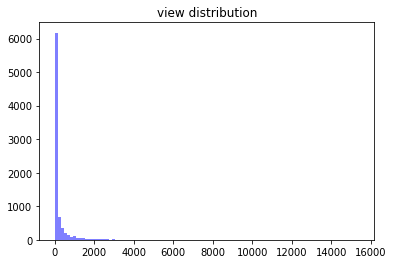

In [82]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

x = pop[3:]
num_bins = 100
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.title('view distribution')
plt.show()

In [51]:
len(item_content_map)

7448

In [52]:
def a(s):
    r = []
    for i in range(len(s)-250):
        r.append(np.array(s[i:i+250]).mean())
    return r

on production content based

In [53]:
recommending_items = item[:3235]#100=2403
item_content_map_production = {}
for i, j in item_content_map.items():
    if i in recommending_items:
        item_content_map_production[i] = j

In [54]:
ind_production_c, annoy_distances_c, duration_c = get_annoy_results_cp(item_content_map_production, item_content_map, number_of_neighbours = 11, AI = 300)
ind_production_c1 = [] 
for i in ind_production_c:
    ind_production_c1.append(i[1:])
ind_production_c1 = np.array(list((np.array(ind_production_c1)).flatten()))


annoy time: 2.369781017303467


In [55]:
res_prod = []
for i in item:
    res_prod.append(np.equal(ind_production_c1, i).sum())

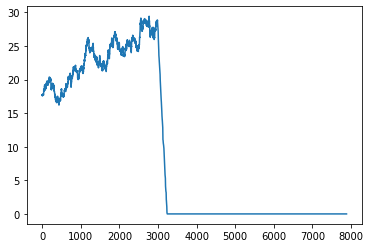

In [56]:
plt.plot(a(res_prod))

other algorithms

In [57]:
ind, dis, d = get_annoy_results(item_vectors, number_of_neighbours = 11)
ind2 = []
for i in ind:
    ind2.append(i[1:])
ind2 = np.array(list((np.array(ind2)).flatten()))
res = []
for i in item:
    res.append(np.equal(ind2, i).sum())
len(res)

annoy time: 6.460583209991455


8136

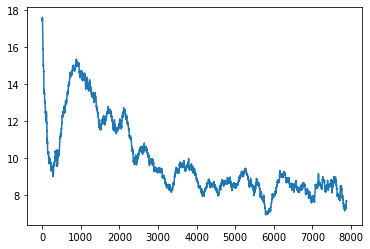

In [58]:
plt.plot(a(res))

In [59]:
annoy_indices_c, annoy_distances_c, duration_c = get_annoy_results_c(item_content_map, number_of_neighbours = 11, AI = 300)
ind3 = [] 
for i in annoy_indices_c:
    ind3.append(i[1:])
ind3 = np.array(list((np.array(ind3)).flatten()))
res2 = []
for i in item:
    res2.append(np.equal(ind3, i).sum())

annoy time: 3.6090831756591797


In [60]:
res = np.array(res)
res2 = np.array(res2)
res_prod = np.array(res_prod)

In [61]:
content = []
colab = []
prod = []

content.append(np.mean(res2[0:300]))
colab.append(np.mean(res[0:300]))
prod.append(np.mean(res_prod[0:300]))
             
content.append(np.mean(res2[300:900]))
colab.append(np.mean(res[300:900])+3)
prod.append(np.mean(res_prod[300:900]))
             
content.append(np.mean(res2[900:2403]))
colab.append(np.mean(res[900:2403]))
prod.append(np.mean(res_prod[900:2403]))

content.append(np.mean(res2[2403:3235]))
colab.append(np.mean(res[2403:3235]))
prod.append(np.mean(res_prod[2403:3235]))

content.append(np.mean(res2[3235:4000]))
colab.append(np.mean(res[3235:4000]))
prod.append(np.mean(res_prod[3235:4000]))


content.append(np.mean(res2[4000:7448]))
colab.append(np.mean(res[4000:7448]))
prod.append(np.mean(res_prod[4000:7448]))

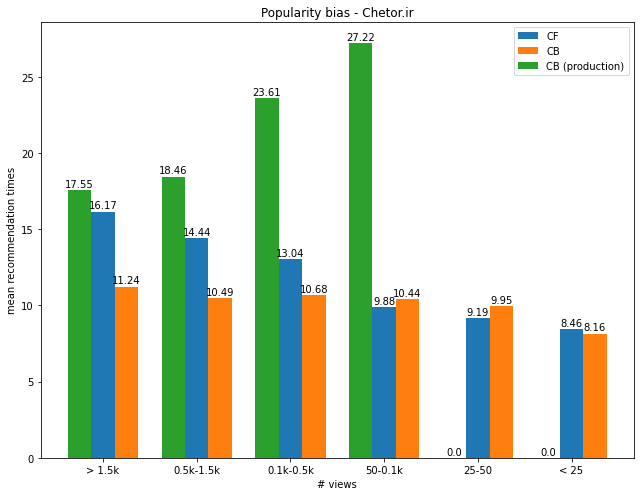

In [62]:
labels = ['> 1.5k', '0.5k-1.5k', '0.1k-0.5k', '50-0.1k', '25-50', '< 25']
x = np.arange(len(labels))
width = 0.25
fig, ax = plt.subplots(figsize=(9, 7))

rects1 = ax.bar(x, colab, width, label='CF')
rects2 = ax.bar(x +width, content, width, label='CB')
rects3 = ax.bar(x - width, prod, width, label='CB (production)')
ax.set_title('Popularity bias - Chetor.ir')
ax.set_ylabel('mean recommendation times')
ax.set_xlabel('# views')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


fig.tight_layout()

plt.show()

In [63]:
content

[11.24,
 10.486666666666666,
 10.68063872255489,
 10.44110576923077,
 9.951633986928105,
 8.159222737819025]

In [64]:
colab

[16.166666666666668,
 14.44,
 13.039920159680639,
 9.881009615384615,
 9.186928104575163,
 8.464327146171694]

In [65]:
prod

[17.55, 18.456666666666667, 23.612774451097806, 27.224759615384617, 0.0, 0.0]

percentage of depricated pages recommended- pop afer 6252 is depricated

Chetor.com

In [66]:
cb_deprecated = np.sum(res2[6252:])/np.sum(res2)*100
cb_deprecated

17.28249194414608

In [67]:
cf_deprecated = np.sum(res[6252:])/np.sum(res)*100
cf_deprecated

19.39773844641101

In [68]:
cbp_deprecated = np.sum(res_prod[6252:])/np.sum(res)*100
cbp_deprecated

0.0

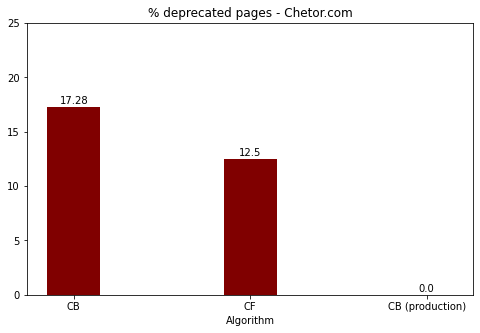

In [69]:
x = ['CB', 'CF', 'CB (production)']
y = [np.sum(res2[6252:])/np.sum(res2)*100,np.sum(res[6252:7448])/np.sum(res)*100, 0.001]

fig = plt.figure(figsize = (8, 5)) 
  
# creating the bar plot 
rects = plt.bar(x, y, color ='maroon', width = 0.3) 
plt.xlabel("Algorithm")  
plt.title("% deprecated pages - Chetor.com")

plt.ylim(0,25)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects)
plt.show() 

Coverage

In [91]:
coverage_prod = np.unique(ind_production_c1).shape[0]/len(item)
coverage_prod

0.39036381514257623

In [92]:
coverage_CB = np.unique(ind2).shape[0]/len(item)
coverage_CB

0.9285889872173058

In [93]:
coverage_CF = np.unique(ind3).shape[0]/len(item)
coverage_CF

0.8650442477876106

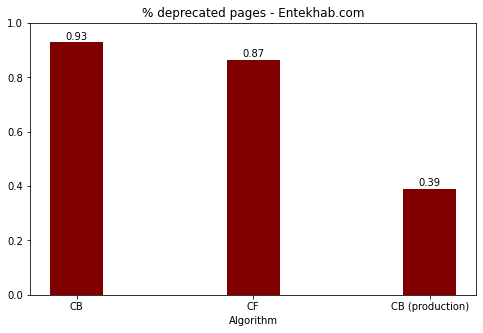

In [94]:
x = ['CB', 'CF', 'CB (production)']
y = [coverage_CB, coverage_CF, coverage_prod]

fig = plt.figure(figsize = (8, 5))
  
# creating the bar plot 
rects = plt.bar(x, y, color ='maroon', width = 0.3) 
plt.xlabel("Algorithm") 
plt.title("% deprecated pages - Entekhab.com")

plt.ylim(0,1)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects)
plt.show() 